<a href="https://colab.research.google.com/github/mrcasu/ecsam_test/blob/main/EESAM_TrafficSignDetectionTF1p15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Enabling the GPU runtime
To speed-up the training phase, we need to run it on GPU. This is possible in Colab by clicking on "Change runtime type" in the **Runtime** menu above and by selecting GPU as hardware accelerator.

## Preparing your data
First of all, to avoid the curse of losing data while you're working on Colab, the best solution is to mount your Drive and create a working directory over there. Run the next code section and follow the instructions to enable mounting your drive (by copying the authorization code). At the end, use the file browser on the left panel to check if folders named EESAM_2022 and EESAM_2022/GTSRB have been created under your home directory 'My Drive'.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir '/content/drive/My Drive/EESAM_2022'
!mkdir '/content/drive/My Drive/EESAM_2022/GTSRB'
!mkdir '/content/GTSRBdataset'

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/EESAM_2022’: File exists
mkdir: cannot create directory ‘/content/drive/My Drive/EESAM_2022/GTSRB’: File exists


Now let's download the GTSRB images in compressed format and a CSV file with the sign names. The GTSRB images have been already pre-processed (to save a non-negligible amount of time) and are ready to use. If you are interested to know how the images have been pre-processed and saved in compressed numpy format (.npz) go to the final section called **Appendix**.

In [ ]:
%cd /content
!gdown --id "1QnAanx2LaIRrGTKYvNmMT7H6-n_CmZdy"
!gdown --id "1s1Zj_HDC1_hOxzmyz_tWdLcdUOIYv_Nu"
!gdown --id "16tzif__4k4g0Lw5OouIhtjJQGsh3kZ9G"
!mv '/content/data_compressed.npz' '/content/drive/My Drive/EESAM_2022/GTSRB'
!mv '/content/signnames.csv' '/content/drive/My Drive/EESAM_2022/GTSRB'
!mv '/content/archive.zip' '/content/GTSRBdataset'

/content
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1QnAanx2LaIRrGTKYvNmMT7H6-n_CmZdy
To: /content/signnames.csv
100% 999/999 [00:00<00:00, 1.85MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1s1Zj_HDC1_hOxzmyz_tWdLcdUOIYv_Nu
To: /content/data_compressed.npz
100% 463M/463M [00:05<00:00, 86.8MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading

## Configuring TF & Keras
To export the final Tensorflow (TF) graph and be able to use it later with the Intel Openvino framework we need to downgrade TF to version 1.15 and Keras to 2.2.5. Notice also that we need to install the GPU version of TF. At the end we check if the 1.15 version of TF has been installed.

In [ ]:
!pip uninstall -y tensorflow
#!pip install tensorflow==1.15 #2.0.0 or tensorflow-gpu
!pip uninstall -y tensorflow-gpu
!pip install tensorflow-gpu==1.15 #2.0.0 or tensorflow-gpu
!pip install keras==2.2.5
!pip uninstall h5py
!pip install h5py==2.10.0
import tensorflow as tf
print(tf.__version__)



Found existing installation: tensorflow 2.9.2
Uninstalling tensorflow-2.9.2:
  Successfully uninstalled tensorflow-2.9.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 411.5 MB 7.7 kB/s 
     |████████████████████████████████| 3.8 MB 48.7 MB/s 
     |████████████████████████████████| 503 kB 45.5 MB/s 
     |████████████████████████████████| 50 kB 7.8 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=0d99fb85b42f7bf8f1b29f7c7b84c34a1152fba1089cee9acb3848d204aa2062
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installati

## Creating the Model
Now we create **TrafficSignNet**, a simple CNN that is described as a Sequential model using Keras layers:

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Input

from keras import backend as K
from tensorflow.keras import layers
import tensorflow as tf

K.clear_session()

### UNCOMMENT THE FOLLOWING IF YOU WANT TO USE FP16
#dtype='float16'
#K.set_floatx(dtype)

# default is 1e-7 which is too small for float16.  Without adjusting the epsilon, we will get NaN predictions because of divide by zero problems
#K.set_epsilon(1e-4)
### END OF COMMENTED SECTION


class TrafficSignNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
    # CONV => RELU => BN => POOL
		model.add(Conv2D(8, (5, 5), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
    # first set of (CONV => RELU => CONV => RELU) * 2 => POOL
		model.add(Conv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(16, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		# second set of (CONV => RELU => CONV => RELU) * 2 => POOL
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
  	# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# second set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model


Using TensorFlow backend.





## Loading the dataset
Using the _load_ function defined in _numpy_, we can load the dataset as a list of arrays from the compressed file. Then we read training and testing data as well as other ancillary arrays from the list. We also print the name of classes of traffic signals in the GTSRB database.

In [ ]:
from numpy import load
loaded=load('/content/drive/My Drive/EESAM_2022/GTSRB/data_compressed.npz')

trainX=loaded['arr_0']
testX=loaded['arr_1']
numLabels=loaded['arr_2']
trainY=loaded['arr_3']
testY=loaded['arr_4']
classTotals=loaded['arr_5']
classWeight=loaded['arr_6']

# load the label names
labelNames = open("/content/drive/My Drive/EESAM_2022/GTSRB/signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]
print("Traffic Signals in the GTSRB dataset:\n")
for i in labelNames:
  print(i)

Traffic Signals in the GTSRB dataset:

Speed limit (20km/h)
Speed limit (30km/h)
Speed limit (50km/h)
Speed limit (60km/h)
Speed limit (70km/h)
Speed limit (80km/h)
End of speed limit (80km/h)
Speed limit (100km/h)
Speed limit (120km/h)
No passing
No passing for vehicles over 3.5 metric tons
Right-of-way at the next intersection
Priority road
Yield
Stop
No vehicles
Vehicles over 3.5 metric tons prohibited
No entry
General caution
Dangerous curve to the left
Dangerous curve to the right
Double curve
Bumpy road
Slippery road
Road narrows on the right
Road work
Traffic signals
Pedestrians
Children crossing
Bicycles crossing
Beware of ice/snow
Wild animals crossing
End of all speed and passing limits
Turn right ahead
Turn left ahead
Ahead only
Go straight or right
Go straight or left
Keep right
Keep left
Roundabout mandatory
End of no passing
End of no passing by vehicles over 3.5 metric tons


## Creating a callback
Now we create a callback to store the best training result (i.e. the best weights) in a checkpoint file.
This callback monitors the validation accuracy (monitor='val_acc') of the trained model at the end of each epoch. When the validation accuracy at the current epoch is higher (mode='max') than the best found so far (save_best_only=True), the callback saves the weights of current model (save_weights_only=True) in a checkpoint file (defined in filepath).

In [ ]:
import tensorflow as tf
checkpoint_filepath = '/content/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc', #val_accuracy in tf 2.0
    mode='max',
    save_best_only=True)


## Data augmentation generator
We can increase the dataset size by applying random rotation, zoom, shift, shear, and flip settings. Notice how we’re not applying horizontal or vertical flips here as traffic signs will never be flipped.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
	rotation_range=10,
	zoom_range=0.15,
	width_shift_range=0.1,
	height_shift_range=0.1,
	shear_range=0.15,
	horizontal_flip=False,
	vertical_flip=False,
	fill_mode="nearest")

Now we define the number of epochs (NUM_EPOCHS), the initial learning rate (INIT_LR), the size of the batch (BS). We also define the optimizer to use (Adam).

Then we can build the model and compile it. We can also print the summary: notice that the number of parameters is relatively small, around 100k (~400kB).

In [ ]:
from tensorflow.keras.optimizers import Adam

NUM_EPOCHS = 30
INIT_LR = 1e-3
BS = 128

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model = TrafficSignNet.build(width=32, height=32, depth=3, classes=numLabels)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


[INFO] compiling model...
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         608       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 8)         0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 8)         32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (

Now we can create PNG images of the network graph (horizontal and vertical)

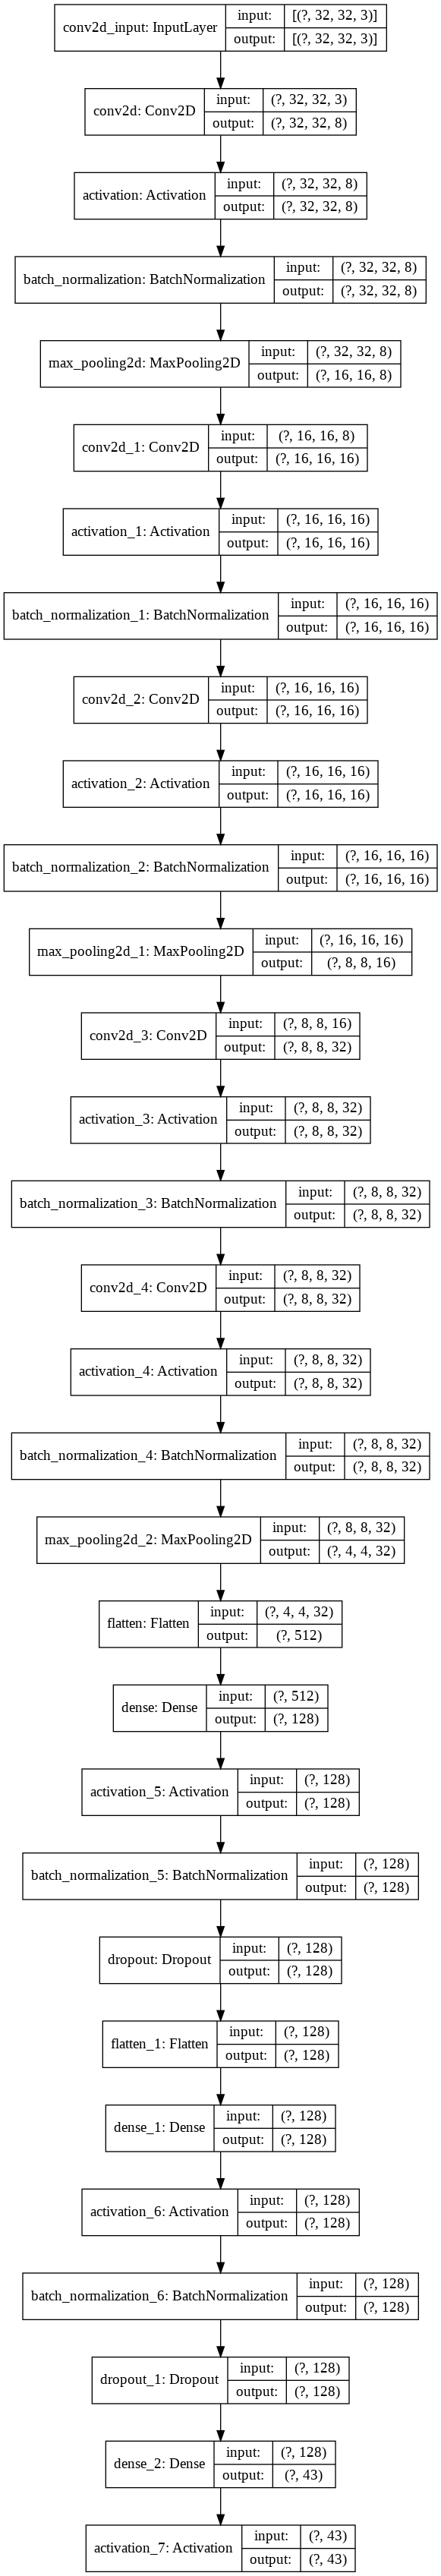

In [ ]:
from tensorflow import keras
keras.utils.plot_model(model, "/content/drive/My Drive/EESAM_2022/GTSRB/trafficsignnetLR.png", show_shapes=True, rankdir="LR")
keras.utils.plot_model(model, "/content/drive/My Drive/EESAM_2022/GTSRB/trafficsignnetTB.png", show_shapes=True, rankdir="TB")

## Training
Now we're ready to start the training. To counterbalance the different number of elements in each class, we can use "weight", obtained from the distribution of the elements in the dataset, and pass it to the _fit_ function (class_weight=weight).

Even though we're using a GPU and the number of parameters is relatively small, be prepared to wait around 10-15 minutes.

In [ ]:
weight = {i : classWeight[i] for i in range(43)}
print(weight)

# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] / BS,
	epochs=NUM_EPOCHS,
	#epochs=10,
  callbacks=[model_checkpoint_callback],
	class_weight=weight,
  verbose=1)

{0: 10.714286, 1: 1.0135136, 2: 1.0, 3: 1.5957447, 4: 1.1363636, 5: 1.2096775, 6: 5.357143, 7: 1.5625, 8: 1.5957447, 9: 1.5306122, 10: 1.119403, 11: 1.7045455, 12: 1.0714285, 13: 1.0416666, 14: 2.8846154, 15: 3.5714285, 16: 5.357143, 17: 2.0270271, 18: 1.875, 19: 10.714286, 20: 6.25, 21: 6.818182, 22: 5.769231, 23: 4.4117646, 24: 8.333333, 25: 1.5, 26: 3.75, 27: 9.375, 28: 4.1666665, 29: 8.333333, 30: 5.0, 31: 2.8846154, 32: 9.375, 33: 3.2656024, 34: 5.357143, 35: 1.875, 36: 5.769231, 37: 10.714286, 38: 1.0869565, 39: 7.5, 40: 6.25, 41: 9.375, 42: 9.375}
[INFO] training network...
Epoch 1/30
307/306 [==============================] - 76s 249ms/step - loss: 8.6137 - acc: 0.1193 - val_loss: 5.0031 - val_acc: 0.0546
Epoch 2/30
307/306 [==============================] - 75s 245ms/step - loss: 5.1622 - acc: 0.3303 - val_loss: 3.2514 - val_acc: 0.1669
Epoch 3/30
307/306 [==============================] - 81s 263ms/step - loss: 3.7556 - acc: 0.4752 - val_loss: 6.3515 - val_acc: 0.0415
Epoch 4

Let's plot the Loss and Accuracy curves vs number of epochs:

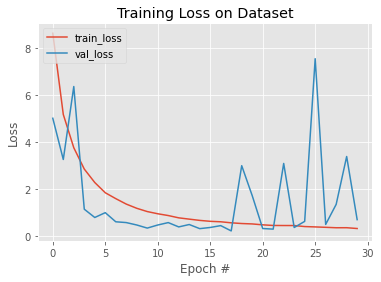

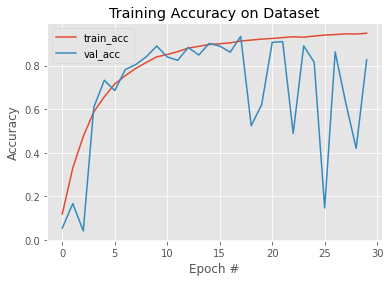

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
#plt.plot(N, H.history["accuracy"], label="train_acc")
#plt.plot(N, H.history["val_accuracy"], label="val_acc")
#plt.plot(N, H.history["acc"], label="train_acc")
#plt.plot(N, H.history["val_acc"], label="val_acc")
#plt.title("Training Loss and Accuracy on Dataset")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
#plt.ylabel("Loss/Accuracy")
plt.ylabel("Loss")
plt.legend(loc="upper left")
plt.show()
plt.figure()
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="upper left")
plt.show()
#plt.savefig(args["plot"])


Let's save the model in a [Hierarchical Data Format (HDF)](https://en.wikipedia.org/wiki/Hierarchical_Data_Format), a file format (.h5) designed to store and organize large amounts of data. It is very common to use it in Keras.

## Testing
Let's run all the predictions through the test set and print some statistics for each class. In particular, the following stats are printed:

* Accuracy - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation over all classes to the total observations. One may think that a model with the highest accuracy is necessarily the best. Yes, accuracy is a great measure, but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model. For our model, if training was done correctly, we should get 0.94 which means our model is approx. 94% accurate.

* Precision - Precision is the ratio of correctly predicted  observations in each class to the total predicted observations for that class (correct and incorrect).

* Recall (Sensitivity) - Recall is the ratio of correctly predicted observations in each class to the all observations we should have in that class.

* F1 score - F1 Score is the harmonic average of Precision and Recall: $$F1 Score = 2*(Recall * Precision) / (Recall + Precision)$$

![wikipedia precision recall](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/EESAM_2022/GTSRB/model/keras_model.h5')
from sklearn.metrics import classification_report
#model.load_weights(checkpoint_filepath)
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))
# save the network to disk
print("[INFO] serializing network to '{}'...".format("trafficsignnet.model"))
model.save("trafficsignnet.model")

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


[INFO] evaluating network...
                                                    precision    recall  f1-score   support

                              Speed limit (20km/h)       0.83      0.88      0.85        60
                              Speed limit (30km/h)       0.94      0.92      0.93       720
                              Speed limit (50km/h)       0.86      0.95      0.91       750
                              Speed limit (60km/h)       0.88      0.93      0.90       450
                              Speed limit (70km/h)       0.96      0.94      0.95       660
                              Speed limit (80km/h)       0.91      0.77      0.83       630
                       End of speed limit (80km/h)       0.94      0.79      0.86       150
                             Speed limit (100km/h)       0.92      0.89      0.90       450
                             Speed limit (120km/h)       0.95      0.90      0.92       450
                                        No passing

Now we take a few samples from the Test folder and annotate the image with predicted label. These images are saved in the EESAM/ GTSRB/examples folder and also printed here in the notebook.

Streaming output truncated to the last 5000 lines.
  inflating: train/5/00005_00053_00012.png  
  inflating: train/5/00005_00053_00013.png  
  inflating: train/5/00005_00053_00014.png  
  inflating: train/5/00005_00053_00015.png  
  inflating: train/5/00005_00053_00016.png  
  inflating: train/5/00005_00053_00017.png  
  inflating: train/5/00005_00053_00018.png  
  inflating: train/5/00005_00053_00019.png  
  inflating: train/5/00005_00053_00020.png  
  inflating: train/5/00005_00053_00021.png  
  inflating: train/5/00005_00053_00022.png  
  inflating: train/5/00005_00053_00023.png  
  inflating: train/5/00005_00053_00024.png  
  inflating: train/5/00005_00053_00025.png  
  inflating: train/5/00005_00053_00026.png  
  inflating: train/5/00005_00053_00027.png  
  inflating: train/5/00005_00053_00028.png  
  inflating: train/5/00005_00053_00029.png  
  inflating: train/5/00005_00054_00000.png  
  inflating: train/5/00005_00054_00001.png  
  inflating: train/5/00005_00054_00002.png  
  in

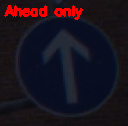

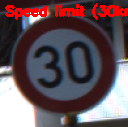

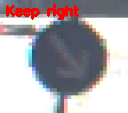

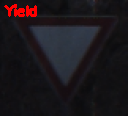

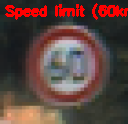

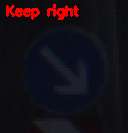

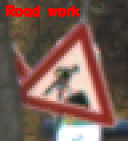

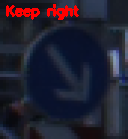

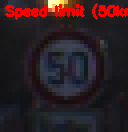

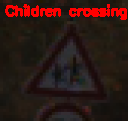

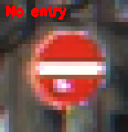

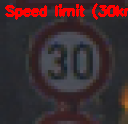

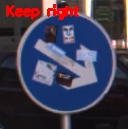

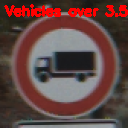

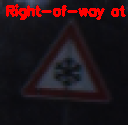

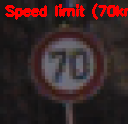

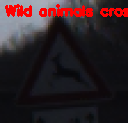

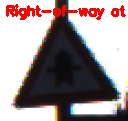

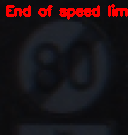

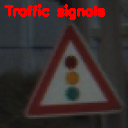

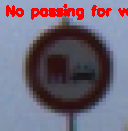

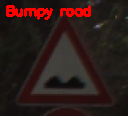

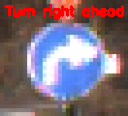

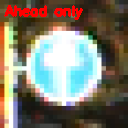

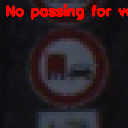

In [ ]:
#import pathlib
import os
import numpy as np
import imutils
from imutils import paths
import random
import cv2
from skimage import io
from skimage import transform
from skimage import exposure

%cd /content/GTSRBdataset/
!unzip archive.zip

# load the label names
labelNames = open("/content/drive/My Drive/EESAM_2022/GTSRB/signnames.csv").read().strip().split("\n")[1:]
#labelNames = open("signnames.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]
# grab the paths to the input images, shuffle them, and grab a sample
print("[INFO] predicting...")
imagePaths = list(paths.list_images('/content/GTSRBdataset/Test'))
print(imagePaths)
random.shuffle(imagePaths)
imagePaths = imagePaths[:25]

os.makedirs('/content/drive/My Drive/EESAM_2022/GTSRB/examples', exist_ok=True)

from IPython.display import Image
#Image('example.png')
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
  # load the image, resize it to 32x32 pixels, and then apply
  # Contrast Limited Adaptive Histogram Equalization (CLAHE),
  # just like we did during training
  #print(imagePath)
  image = io.imread(imagePath)
  image = transform.resize(image, (32, 32))
  image = exposure.equalize_adapthist(image, clip_limit=0.1)
  # preprocess the image by scaling it to the range [0, 1]
  image = image.astype("float32") / 255.0
  image = np.expand_dims(image, axis=0)
  # make predictions using the traffic sign recognizer CNN
  preds = model.predict(image)
  j = preds.argmax(axis=1)[0]
  #print(j)
  label = labelNames[j]
  # load the image using OpenCV, resize it, and draw the label
  # on it
  image = cv2.imread(imagePath)
  image = imutils.resize(image, width=128)
  cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
  # save the image to disk
  p = os.path.sep.join(['/content/drive/My Drive/EESAM_2022/GTSRB/examples', "{}.png".format(i)])
  #print(p)
  cv2.imwrite(p, image)
  Image(p)

imagePaths = list(paths.list_images('/content/drive/My Drive/EESAM_2022/GTSRB/examples'))
#print(imagePaths)
import  time
for (i, imagePath) in enumerate(imagePaths):
  display(Image(imagePath))


## Exporting the tensorflow graph

Finally, we save the tensorflow graph that can be exported to run the inference in another device.  We save it both in binary format (.pb) and in text format (.pbtxt). It is indeed instructive to open the latter with an editor to see how the Keras layers have been transformed into the atomic operations that are the vertices of the Tensorflow graph.

In [ ]:
import os
import sys

import argparse

from pathlib import Path

import tensorflow as tf
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io

from keras import backend as K
from keras.models import load_model


def setKerasOptions():
    K._LEARNING_PHASE = tf.constant(0)
    K.set_learning_phase(False)
    K.set_learning_phase(0)
    K.set_image_data_format('channels_last')


def getInputParameters():
    parser = argparse.ArgumentParser()
    parser.add_argument('--input_model', '-m', required=True, type=str, help='Path to Keras model.')
    parser.add_argument('--num_outputs', '-no', required=False, type=int, help='Number of outputs. 1 by default.', default=1)

    return parser


def export_keras_to_tf(input_model, output_model, num_output):
    print('Loading Keras model: ', input_model)

    keras_model = load_model(input_model)

    print(keras_model.summary())

    predictions = [None] * num_output
    predrediction_node_names = [None] * num_output

    for i in range(num_output):
        predrediction_node_names[i] = 'output_node' + str(i)
        predictions[i] = tf.identity(keras_model.outputs[i], name=predrediction_node_names[i])

    sess = K.get_session()

    constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), predrediction_node_names)
    infer_graph = graph_util.remove_training_nodes(constant_graph)

    graph_io.write_graph(infer_graph, '.', output_model, as_text=False)


import tensorflow as tf

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        # Graph -> GraphDef ProtoBuf
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph


from tensorflow.keras import backend as K
# This line must be executed before loading Keras model.
K.set_learning_phase(0)

from tensorflow.keras.models import load_model
model_saved = load_model('/content/drive/My Drive/EESAM_2022/GTSRB/model/keras_model.h5')
print(model_saved.outputs)
# [<tf.Tensor 'dense_2/Softmax:0' shape=(?, 10) dtype=float32>]
print(model_saved.inputs)
# [<tf.Tensor 'conv2d_1_input:0' shape=(?, 28, 28, 1) dtype=float32>]

frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model_saved.outputs])

# Save to ./model/tf_model.pb
tf.train.write_graph(frozen_graph, "model", "/content/drive/My Drive/EESAM_2022/GTSRB/model/tf_model.pb", as_text=False)
# Save to ./model/tf_model.pbtxt
tf.train.write_graph(frozen_graph, "model", "/content/drive/My Drive/EESAM_2022/GTSRB/model/tf_model.pbtxt", as_text=True)

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


[<tf.Tensor 'activation_7_2/Softmax:0' shape=(?, 43) dtype=float32>]
[<tf.Tensor 'conv2d_input_2:0' shape=(?, 32, 32, 3) dtype=float32>]


'/content/drive/My Drive/EESAM_2022/GTSRB/model/tf_model.pbtxt'

# APPENDIX

Here are the steps needed to obtain from the GTSRB images the numpy compressed file (.npz) containing the training and test arrays. Be prepared to wait for ~15 minutes in order to process all the images.

In [ ]:
def load_split(basePath, csvPath):
	# initialize the list of data and labels
	data = []
	labels = []
	# load the contents of the CSV file, remove the first line (since
	# it contains the CSV header), and shuffle the rows (otherwise
	# all examples of a particular class will be in sequential order)
	rows = open(csvPath).read().strip().split("\n")[1:]
	random.shuffle(rows)
 	# loop over the rows of the CSV file
	for (i, row) in enumerate(rows):
		# check to see if we should show a status update
		if i > 0 and i % 1000 == 0:
			print("[INFO] processed {} total images".format(i))
		# split the row into components and then grab the class ID
		# and image path
		(label, imagePath) = row.strip().split(",")[-2:]
		# derive the full path to the image file and load it
		imagePath = os.path.sep.join([basePath, imagePath])
		image = io.imread(imagePath)
  # resize the image to be 32x32 pixels, ignoring aspect ratio,
		# and then perform Contrast Limited Adaptive Histogram
		# Equalization (CLAHE)
		image = transform.resize(image, (32, 32))
		image = exposure.equalize_adapthist(image, clip_limit=0.1)
		# update the list of data and labels, respectively
		data.append(image)
		labels.append(int(label))
	# convert the data and labels to NumPy arrays
	data = np.array(data)
	labels = np.array(labels)
	# return a tuple of the data and labels
	return (data, labels)

import pathlib
from tensorflow.keras.utils import to_categorical

%cd '/content/GTSRBdataset'
pwd=pathlib.Path().absolute()
datasetpath = str(pwd)
# derive the path to the training and testing CSV files
trainPath = os.path.sep.join([datasetpath, "Train.csv"])
testPath = os.path.sep.join([datasetpath, "Test.csv"])
# load the training and testing data
print("[INFO] loading training and testing data...")
#(trainX, trainY) = load_split(datasetpath, trainPath)
#(testX, testY) = load_split(datasetpath, testPath)
# scale data to the range of [0, 1]
#trainX = trainX.astype("float32") / 255.0
#testX = testX.astype("float32") / 255.0
# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY))
trainY = to_categorical(trainY, numLabels)
testY = to_categorical(testY, numLabels)
# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

from numpy import savez_compressed
savez_compressed('/content/drive/My Drive/EESAM_2022/GTSRB/data2_compressed.npz', trainX, testX, numLabels, trainY, testY, classTotals, classWeight)